### image classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Importing the data

In [2]:
import os

identifying training and testing set and loading them into variables

In [3]:
base_dir = r'E:\Datasets_python_files_Imarticus\Imarticus project datasets\CV\CV\Dataset\House_dataset\House_dataset'
train_dir = os.path.join(base_dir, 'Training')
print (train_dir)

test_dir = os.path.join(base_dir, 'Testing')
print (test_dir)

E:\Datasets_python_files_Imarticus\Imarticus project datasets\CV\CV\Dataset\House_dataset\House_dataset\Training
E:\Datasets_python_files_Imarticus\Imarticus project datasets\CV\CV\Dataset\House_dataset\House_dataset\Testing


### Exploratory data analysis

In [4]:
# Directory with our house pictures
train_house_dir = os.path.join(train_dir, 'House')

# Directory with our not house pictures
train_nothouse_dir = os.path.join(train_dir, 'Not_House')

In [5]:
train_house_fnames = os.listdir(train_house_dir)
print(train_house_fnames[:10])

train_nothouse_fnames = os.listdir(train_nothouse_dir)
print(train_nothouse_fnames[:10])

['house (1).jpeg', 'house (1).jpg', 'house (1).png', 'house (10).jpg', 'house (10).png', 'house (100).jpg', 'house (1000).jpg', 'house (1001).jpg', 'house (1002).jpg', 'house (1003).jpg']
['Not_House (1).jpg', 'Not_House (10).jpg', 'Not_House (100).jpg', 'Not_House (1000).jpg', 'Not_House (1001).jpg', 'Not_House (1002).jpg', 'Not_House (1003).jpg', 'Not_House (1004).jpg', 'Not_House (1005).jpg', 'Not_House (1006).jpg']


### Checking for total number of images  

In [6]:
print('total training house images:', len(os.listdir(train_house_dir)))
print('total training not house images:', len(os.listdir(train_nothouse_dir)))
print('total testing mixed images:', len(os.listdir(test_dir)))

total training house images: 1069
total training not house images: 1085
total testing mixed images: 579


We have 1069 house images and 1085 not house images 

For training our model and 579 images to test the model.

In [7]:
%matplotlib inline
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

verifying the image from the source location

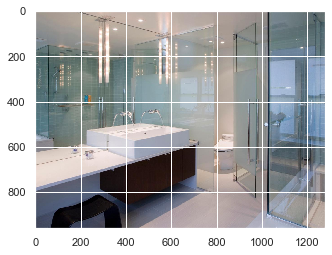

In [8]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(r'E:\Datasets_python_files_Imarticus\Imarticus project datasets\CV\CV\Dataset\House_dataset\House_dataset\Testing\Image (5).jpeg')
imgplot = plt.imshow(img)
plt.show()

From house and not house 8 images are chosen seen for our reference

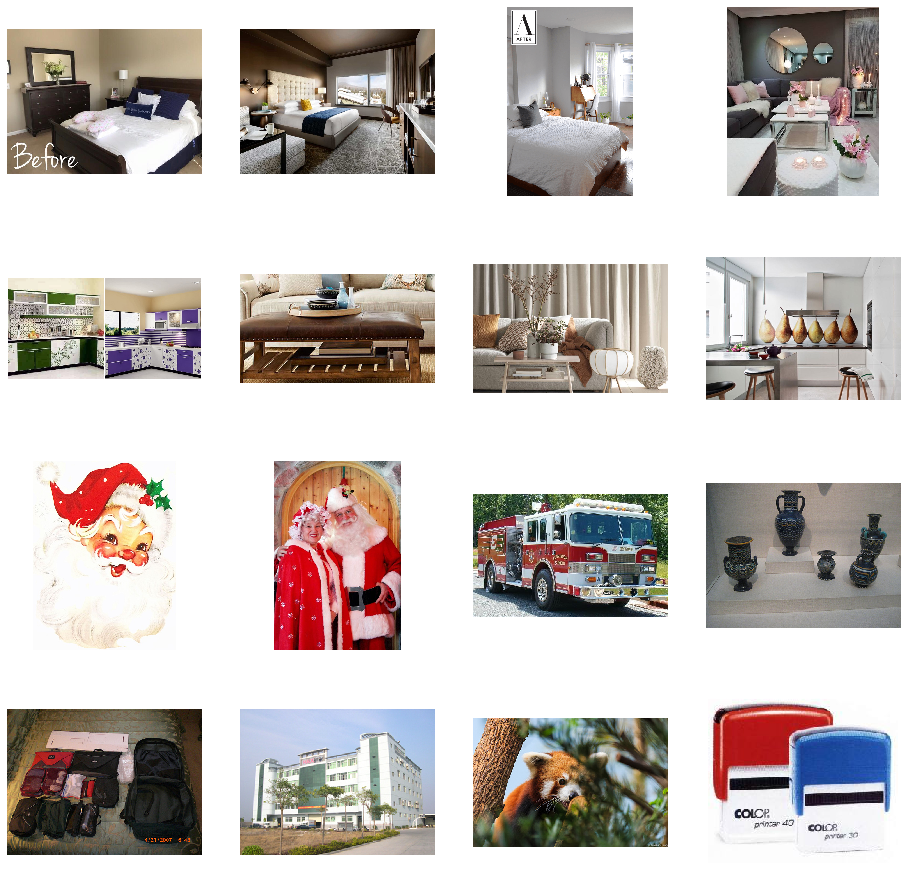

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_house_pix = [os.path.join(train_house_dir, fname) 
                for fname in train_house_fnames[pic_index-8:pic_index]]
next_nothouse_pix = [os.path.join(train_nothouse_dir, fname) 
                for fname in train_nothouse_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_house_pix+next_nothouse_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### Image preprocessing

extracting images from the directories and combining them into a training dataset to be used for training our model

In [10]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

In [11]:
import glob

os.listdir(r'E:\Datasets_python_files_Imarticus\Imarticus project datasets\CV\CV\Dataset\House_dataset\House_dataset\Training')

['House', 'Not_House']

Basic Preprocessing of image for training the model and fit it 

In [12]:
data = []
labels = []

for img_path in glob.glob(r'E:\Datasets_python_files_Imarticus\Imarticus project datasets\CV\CV\Dataset\House_dataset\House_dataset\Training\**\*.*'):
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(os.path.split(os.path.split(img_path)[0])[1])

E:\Datasets_python_files_Imarticus\Imarticus project datasets\CV\CV\Dataset\House_dataset\House_dataset\Training\Not_House\Not_House (999).jpg


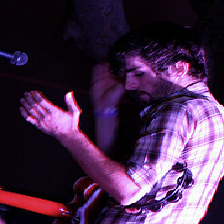

In [13]:
print(img_path)
load_img(img_path, target_size=(224, 224))

In [14]:
# binary encoding all labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

Splitting training and validation datasets

In [15]:
from sklearn.model_selection import train_test_split
(X_train, X_valid, y_train, y_valid) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=9)


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

preparing the model for image classification using mobilenet. It is very small and fast as compared to VGG16 but have comaparable accuracy


In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.optimizers import Adam


In [18]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 40

In [19]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
Model_i = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
Model_main = Model_i.output
Model_main = AveragePooling2D(pool_size=(7, 7))(Model_main)
Model_main = Flatten(name="flatten")(Model_main)
Model_main = Dense(128, activation="relu")(Model_main)
Model_main = Dropout(0.6)(Model_main)
Model_main = Dense(128, activation="relu")(Model_main)
Model_main = Dropout(0.2)(Model_main)
Model_main = Dense(2, activation="softmax")(Model_main)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=Model_i.input, outputs=Model_main)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in Model_i.layers:
	layer.trainable = False

In [20]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [21]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

### Training the model

In [22]:
ans = model.fit(aug.flow(X_train, y_train, batch_size=BS),steps_per_epoch=len(X_train) // BS,validation_data=(X_valid, y_valid),
	validation_steps=len(X_valid) // BS,epochs=EPOCHS)


Epoch 1/10
43/43 [==============================] - 56s 1s/step - loss: 0.6237 - accuracy: 0.6797 - val_loss: 0.2866 - val_accuracy: 0.9304
Epoch 2/10
43/43 [==============================] - 55s 1s/step - loss: 0.3245 - accuracy: 0.8639 - val_loss: 0.1536 - val_accuracy: 0.9559
Epoch 3/10
43/43 [==============================] - 55s 1s/step - loss: 0.2113 - accuracy: 0.9323 - val_loss: 0.1022 - val_accuracy: 0.9745
Epoch 4/10
43/43 [==============================] - 58s 1s/step - loss: 0.1656 - accuracy: 0.9430 - val_loss: 0.0718 - val_accuracy: 0.9838
Epoch 5/10
43/43 [==============================] - 54s 1s/step - loss: 0.1271 - accuracy: 0.9608 - val_loss: 0.0687 - val_accuracy: 0.9838
Epoch 6/10
43/43 [==============================] - 55s 1s/step - loss: 0.1311 - accuracy: 0.9578 - val_loss: 0.0607 - val_accuracy: 0.9838
Epoch 7/10
43/43 [==============================] - 54s 1s/step - loss: 0.1152 - accuracy: 0.9620 - val_loss: 0.0645 - val_accuracy: 0.9861
Epoch 8/10
43/43 [==

In [23]:
ans.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

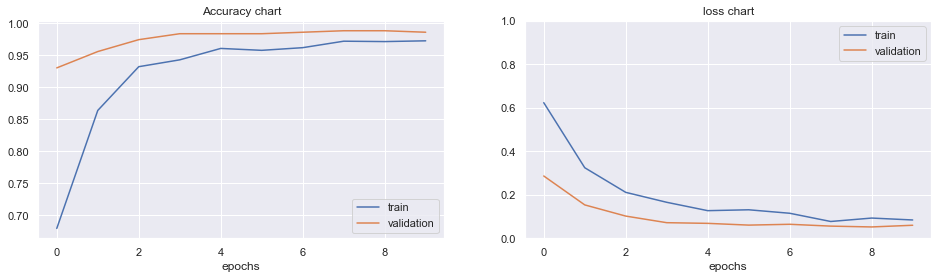

In [24]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(ans.history['accuracy'],label="train")
ax.plot(ans.history['val_accuracy'], label="validation")
ax.set_title("Accuracy chart")
ax.set_xlabel("epochs")
plt.legend()
ax2 = fig.add_subplot(122)
ax2.plot(ans.history['loss'],label="train")
ax2.plot(ans.history['val_loss'],label="validation")
ax2.set_title("loss chart")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)
plt.legend()
plt.show();

In [25]:

from sklearn.metrics import classification_report
# for each image in the testing set we need to find the index of the
y_pred_train = model.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)


# show a nicely formatted classification report
print("training and predicted values classification report")
print(classification_report(y_train.argmax(axis=1),y_pred_train ))

training and predicted values classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       855
           1       1.00      0.98      0.99       868

    accuracy                           0.99      1723
   macro avg       0.99      0.99      0.99      1723
weighted avg       0.99      0.99      0.99      1723



In [26]:
y_pred_val = model.predict(X_valid)
y_pred_val = np.argmax(y_pred_val, axis=1)

# show a nicely formatted classification report
print("training and predicted values classification report")
print(classification_report(y_valid.argmax(axis=1),y_pred_val ))

training and predicted values classification report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       214
           1       1.00      0.97      0.99       217

    accuracy                           0.99       431
   macro avg       0.99      0.99      0.99       431
weighted avg       0.99      0.99      0.99       431



### Predicting the probability of the image

In [27]:
#check for testing/random image if it is a house or not house

# process an image to be mobilenet friendly
def process_image(img_path):
  img = load_img(img_path, target_size=(224, 224))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  pImg = preprocess_input(img_array)
  return pImg

# load an image from file
img_path=r'E:\Datasets_python_files_Imarticus\Imarticus project datasets\CV\CV\Dataset\House_dataset\House_dataset\Testing\Image (10).jpeg'

# process the test image
pImg = process_image(img_path)

# make predictions on test image using mobilenet
prediction = model.predict(pImg)

In [28]:
prediction

array([[0.99631006, 0.00368991]], dtype=float32)

It is a house


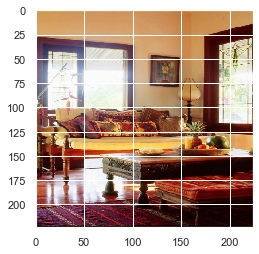

In [29]:


if prediction[0][0]>=0.6:
  print("It is a house")
elif prediction[0][1]>=0.4:
  print("It is not a house")


#the actual uploaded image can be seen from here
img = load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()
 

In [39]:
val_img = []
val_labels = []


for img in os.listdir(test_dir):
  img_path = os.path.join(test_dir, img)
  val_img.append(img)
  #after defining the path of each image send it to process function
  image = process_image(img_path)
  predicted = model.predict(image)#make the prediction for each image

  if predicted[0][0]>=0.6:
    val_labels.append('House image')
  elif predicted[0][1]>=0.4:
    val_labels.append('Not_House image')
  

In [40]:
val_img=pd.Series(val_img)

In [41]:
val_labels=pd.Series(val_labels)

In [42]:
data={'Image':val_img,'Label':val_labels}

In [43]:
data=pd.DataFrame(data)
data.head()

,Image,Label
0,Image (1).jpeg,House image
1,Image (1).jpg,House image
2,Image (1).png,House image
3,Image (10).jpeg,House image
4,Image (10).jpg,House image


In [44]:
data.to_csv(r'E:\Datasets_python_files_Imarticus\bootcamp datasets\predictions.csv')